# Xray image Classification with PyTorch ResNet
this project makes use of a residual network to classify different classes of pathologies based on xray images.

### dataset classes
- class1 : pneumonia
- class 2: normal


In [1]:
# install missing packages
!pip -q install torchsummary

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pathlib import Path

# set background color to white
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# set default figure size
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [16]:
#!ls chest_Xray/
DATA_DIR = r'chest_Xray/train'

test.tar.gz  train  train.tar.gz  val.tar.gz


exploring the images and their classes before modeling

In [17]:
# Get filepaths and labels
image_dir = Path(DATA_DIR)
filepaths = list(image_dir.glob(r'**/*.jpeg'))
#print(filepaths)
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# remove GT from some label names
image_df['Label'] = image_df['Label'].apply(lambda x: x.replace(" GT", ""))

[PosixPath('chest_Xray/train/PNEUMONIA/person1353_virus_2333.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person548_bacteria_2297.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person670_virus_1256.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person961_virus_1634.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person328_virus_681.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person963_virus_1636.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person1277_bacteria_3240.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person1254_virus_2130.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person512_bacteria_2154.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person807_virus_1441.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person387_bacteria_1772.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person261_bacteria_1225.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person646_bacteria_2538.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/person280_bacteria_1321.jpeg'), PosixPath('chest_Xray/train/PNEUMONIA/

In [18]:
image_df

Filepath      Label
0     chest_Xray/train/PNEUMONIA/person1353_virus_23...  PNEUMONIA
1     chest_Xray/train/PNEUMONIA/person548_bacteria_...  PNEUMONIA
2     chest_Xray/train/PNEUMONIA/person670_virus_125...  PNEUMONIA
3     chest_Xray/train/PNEUMONIA/person961_virus_163...  PNEUMONIA
4     chest_Xray/train/PNEUMONIA/person328_virus_681...  PNEUMONIA
...                                                 ...        ...
5211  chest_Xray/train/NORMAL/NORMAL2-IM-0558-0001.jpeg     NORMAL
5212  chest_Xray/train/NORMAL/NORMAL2-IM-0526-0001.jpeg     NORMAL
5213          chest_Xray/train/NORMAL/IM-0711-0001.jpeg     NORMAL
5214          chest_Xray/train/NORMAL/IM-0561-0001.jpeg     NORMAL
5215  chest_Xray/train/NORMAL/NORMAL2-IM-1109-0001.jpeg     NORMAL

[5216 rows x 2 columns]

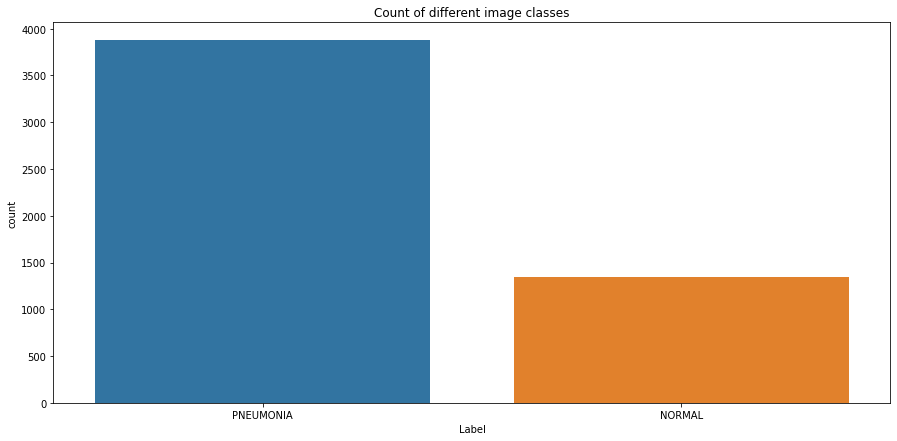

In [19]:
# count plot for each class
sns.countplot(x='Label', data=image_df).set(title='Count of different image classes')
plt.show()

there are 2000 images of each class, which means our model won't be biased towereds a particular class because it has a larger sample size

In [20]:
# the images are already augumented so no need to do any transforms
trans = transforms.Compose([transforms.Resize([128, 128]), # resize to a smaller size to avoid CUDA running out of memory
                            transforms.ToTensor()
                           ])

images = ImageFolder(root=DATA_DIR, transform=trans)

In [21]:
# split data to train, test
size = len(images)
test_size = int(0.2 * size)
train_size = int(size - test_size)
print(f"number of classes: {len(images.classes)}")
print(f"total number of images: {size}")
print(f"total number of train images: {train_size}")
print(f"total number of test images: {test_size}")
# random_split
train_set, test_set = random_split(images, (train_size, test_size))

number of classes: 2
total number of images: 5216
total number of train images: 4173
total number of test images: 1043


In [22]:
# show a single image
def show_image(img, label, dataset):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(dataset.classes[label])

In [23]:
show_image(*train_set[7], train_set.dataset)

In [24]:
show_image(*train_set[101], train_set.dataset)

In [25]:
# create data loaders
batch_size = 64 # larger numbers lead to CUDA running out of memory
train_dl = DataLoader(train_set, batch_size=batch_size)
test_dl = DataLoader(test_set, batch_size=batch_size)

In [26]:
# visualize a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

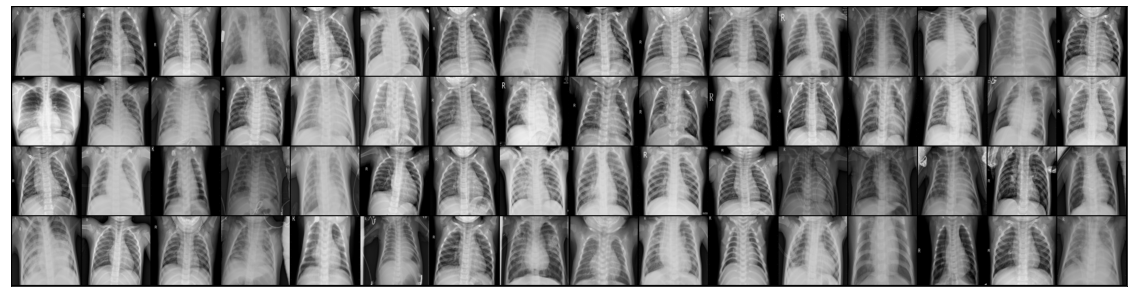

In [28]:
show_batch(train_dl)

In [32]:
# convlutional block with batchnorm and max pooling
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    

# CNN with residual connections
class XrayChestResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512 * 4 * 4, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # add residual
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out # add residual
        out = self.classifier(out)
        return out
        

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device accordingly
model = XrayChestResNet(3, 9).to(device) # 3 color channels and 9 output classes
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# model summary (helps in understanding the output shapes)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [36]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [37]:
# training loop
epochs = 10
losses = []
for epoch in range(epochs):
    # for custom progress bar
    with tqdm(train_dl, unit="batch") as tepoch:
        epoch_loss = 0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            data, target = data.to(device), target.to(device) # move input to GPU
            out = model(data)
            loss = criterion(out, target)
            acc = multi_acc(out, target)
            epoch_loss += loss.item()
            loss.backward()
            optim.step()
            optim.zero_grad()
            tepoch.set_postfix(loss = loss.item(), accuracy = acc.item()) # show loss and accuracy per batch of data
    losses.append(epoch_loss)

Epoch 10: 100%|██████████| 66/66 [01:02<00:00,  1.06batch/s, accuracy=77, loss=1.2]      


we can see that the batch loss is decreasing on each epoch meaning the model is learning effectively, the accuracy also keeps raising the longer we train, to make the loss easier to understand lets plot it

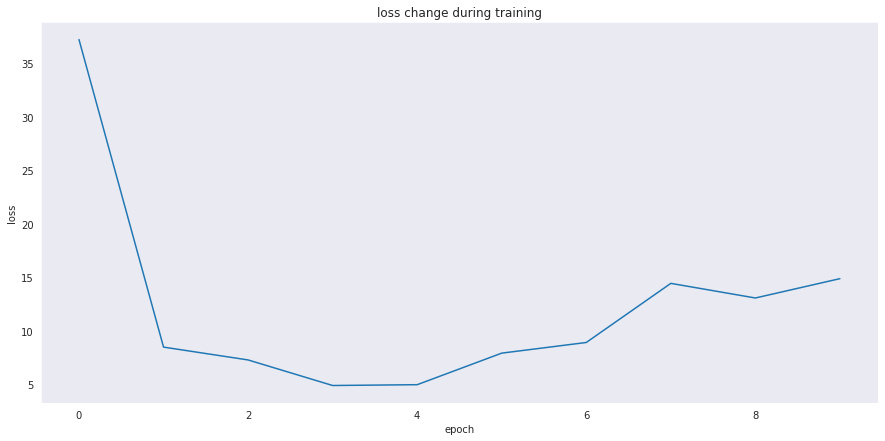

In [38]:
# plot losses
sns.set_style("dark")
sns.lineplot(data=losses).set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.show()

In [39]:
# predict on testing data samples (the accuracy here is batch accuracy)
y_pred_list = []
y_true_list = []
with torch.no_grad():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            acc = multi_acc(y_test_pred, labels)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            tepoch.set_postfix(accuracy = acc.item())
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

100%|██████████| 17/17 [00:12<00:00,  1.35batch/s, accuracy=100]


In [40]:
# flatten prediction and true lists
flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")

number of testing samples results: 1043


In [41]:
# calculate total testing accuracy
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

Testing accuracy is: 94.15%


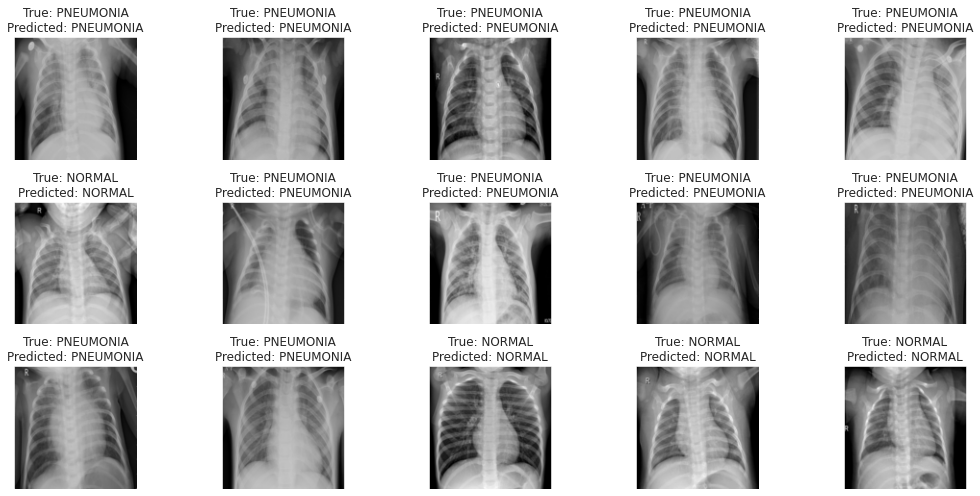

In [42]:
# Display 15 random picture of the dataset with their labels
inds = np.random.randint(len(test_set), size=15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in zip(inds, axes.flat):
    img, label = test_set[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {test_set.dataset.classes[label]}\nPredicted: {test_set.dataset.classes[flat_pred[i]]}")
plt.tight_layout()
plt.show()

In [43]:
# classification report
print(classification_report(flat_true, flat_pred, target_names=images.classes))

              precision    recall  f1-score   support

      NORMAL       0.82      0.99      0.90       272
   PNEUMONIA       1.00      0.92      0.96       771

    accuracy                           0.94      1043
   macro avg       0.91      0.96      0.93      1043
weighted avg       0.95      0.94      0.94      1043



In [44]:
# plot confusion matrix
idx2class = {v: k for k, v in images.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

## Conclusion
in this project we classified x different classes of xray images at an decent accuracy of xx% with most of the classes having good percision and recall, however the model can be improved further by employing some techniques such as:

- Transfer learning: using pre-trained models.
- Learning rate scheduling: chaging the learning rate throughout the training process.
- Gradient clipping: setting threshold for gradient values.
- using Dropout layers.